<a href="https://colab.research.google.com/github/ShowkatImam/try/blob/main/suicidal_ideation_Doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Upload DataSet In CSV form

In [150]:
from google.colab import drive
drive.mount('/content/drive1')

Drive already mounted at /content/drive1; to attempt to forcibly remount, call drive.mount("/content/drive1", force_remount=True).


In [151]:
df = pd.read_csv('/content/drive1/MyDrive/suicide_watch_try12.csv',encoding= 'unicode_escape')
df.head(10)

,Post,Ideation
0,might fuck around and kill myself,1
1,Life is the procrastination of death and I am ...,1
2,Every night I contemplate suicide and every ti...,1
3,I hate that Im living for other people,1
4,I hate my circumstances. I really don't see ho...,1
5,yesterday i tried to kill myself with a knife ...,1
6,"I need to kill myself. This summer, June 29. I...",1
7,I'm a junkie who watched the love of my life c...,1
8,never failed harder in school than this year. ...,1
9,"I will die alone. Hurt this, I dont really car...",1


In [152]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r' ', text)
    text = text.lower()
    return text

In [265]:
df['Post']=df['Post'].apply(str)

In [266]:
df['Post'] = df['Post'].apply(cleanText)
    

remove punctuation mark

In [232]:
import string
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

In [156]:
#df['Post'] = df['Post'].apply(remove_punctuation)
df.head(10)

,Post,Ideation
0,might fuck around and kill myself,1
1,life is the procrastination of death and i am ...,1
2,every night i contemplate suicide and every ti...,1
3,i hate that im living for other people,1
4,i hate my circumstances i really dont see how ...,1
5,yesterday i tried to kill myself with a knife ...,1
6,i need to kill myself this summer june 29 i ha...,1
7,im a junkie who watched the love of my life co...,1
8,never failed harder in school than this year p...,1
9,i will die alone hurt this i dont really care ...,1


In [267]:
df['Ideation'].value_counts()

1    1538
0    1166
Name: Ideation, dtype: int64

In [268]:
df['Post']

0                       might fuck around and kill myself
1       life is the procrastination of death and i am ...
2       every night i contemplate suicide and every ti...
3                 i hate that im living for other people
4       i hate my circumstances i really dont see how ...
                              ...                        
2699    the only way thermodynamics are funny a thermo...
2700    a thief broke into my house last night he was ...
2701    why do they allow people in wheelchairs to bri...
2702    depression i was so depressed last night think...
2703    what do you call a cow thats had an abortion d...
Name: Post, Length: 2704, dtype: object

Stop Word removing And Streaming

In [269]:
import string 
import nltk 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [270]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
ps = PorterStemmer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['Post'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [271]:
corpus

['might fuck around kill',
 'life procrastin death plan take action',
 'everi night contempl suicid everi time think parent would feel want sad guilti way kill without happen recent slowli care less would feel idk feel like live timer close end soon know',
 'hate live peopl',
 'hate circumst realli dont see im continu havent caught break decad one tragedi next world unbeliev harsh feel crazi like im live age dinosaur tri get eaten',
 'yesterday tri kill knife save im mental hospit mom hate girlfriend go leav think dont know im go suffoc',
 'need kill summer june method plan write note think realli kill die point inevit certain say die natur know mean would actual speed process happen either way get death alway finish line die matter die coupl year earlier plan death death matter happen suicid natur death liter thing execut differ way',
 'im junki watch love life commit suicid',
 'never fail harder school year probabl go summer school make want mf kill jesu christ dumb',
 'die alon hurt

Doc2vec Feature Extraction

In [272]:
from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    
    labeled = []
    for i, v in enumerate(corpus):
       label = label_type + '_' + str(i)
       labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled
    


train test spliting

In [327]:
X=df.Post
from sklearn.model_selection import train_test_split
y= df.Ideation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.33)


In [328]:
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test
len(all_data)

2704

In [329]:
model_dbow = Doc2Vec(dm=0, vector_size=5000, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])


100%|██████████| 2704/2704 [00:00<00:00, 323116.75it/s]


In [330]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 2704/2704 [00:00<00:00, 1436347.27it/s]


CPU times: user 1min 37s, sys: 457 ms, total: 1min 37s
Wall time: 51 s


In [332]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [333]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 5000, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 5000, 'Test')


In [334]:
train_vectors_dbow.shape



(1811, 5000)

Machine Learnig classification Algo

In [335]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(train_vectors_dbow, y_train)

LogisticRegression(multi_class='multinomial')

In [336]:
import matplotlib.pyplot as plt

In [338]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [339]:
from sklearn.metrics import classification_report
from sklearn import metrics
import numpy as np
import itertools

accuracy:   0.92161
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       383
           1       0.93      0.94      0.93       510

    accuracy                           0.92       893
   macro avg       0.92      0.92      0.92       893
weighted avg       0.92      0.92      0.92       893



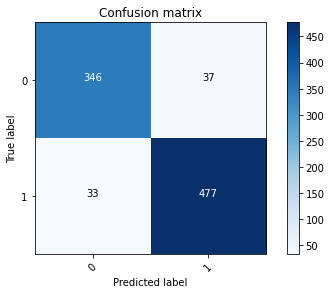

In [340]:
logreg.fit(train_vectors_dbow, y_train)
pred =logreg.predict(test_vectors_dbow)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.5f" % score)
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['0', '1'])
print(classification_report(y_test,pred))

In [341]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=6, random_state=1)

accuracy:   0.82419
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       383
           1       0.87      0.82      0.84       510

    accuracy                           0.82       893
   macro avg       0.82      0.82      0.82       893
weighted avg       0.83      0.82      0.82       893



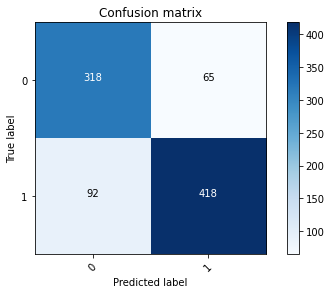

In [342]:
dt.fit(train_vectors_dbow, y_train)
pred15 =dt.predict(test_vectors_dbow)
score15 = metrics.accuracy_score(y_test, pred15)
print("accuracy:   %0.5f" % score15)
cm15 = metrics.confusion_matrix(y_test, pred15)
plot_confusion_matrix(cm15, classes=['0', '1'])
print(classification_report(y_test,pred15))

In [343]:
from sklearn.svm import SVC 

svm = SVC(kernel='linear', C=1E10)
#svm.fit(train_vectors_dbow, y_train)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf.fit(train_vectors_dbow, y_train)


OneVsRestClassifier(estimator=SVC(class_weight='balanced', kernel='linear',
                                  probability=True))

accuracy:   0.917
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       383
           1       0.93      0.92      0.93       510

    accuracy                           0.92       893
   macro avg       0.91      0.92      0.92       893
weighted avg       0.92      0.92      0.92       893



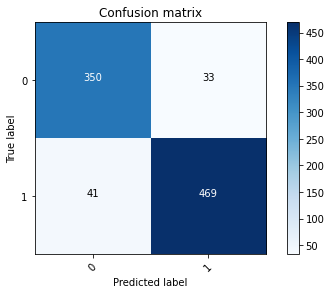

In [344]:
pred5 =clf.predict(test_vectors_dbow)
score5 = metrics.accuracy_score(y_test, pred5)
print("accuracy:   %0.3f" % score5)
cm5 = metrics.confusion_matrix(y_test, pred5)
plot_confusion_matrix(cm5, classes=['0', '1'])
print(classification_report(y_test,pred5))

In [345]:
from sklearn.linear_model import PassiveAggressiveClassifier
linear_clf = PassiveAggressiveClassifier(max_iter=50)
linear_clf.fit(train_vectors_dbow, y_train)

PassiveAggressiveClassifier(max_iter=50)

accuracy:   0.862
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.77      0.96      0.86       383
           1       0.96      0.79      0.87       510

    accuracy                           0.86       893
   macro avg       0.87      0.87      0.86       893
weighted avg       0.88      0.86      0.86       893



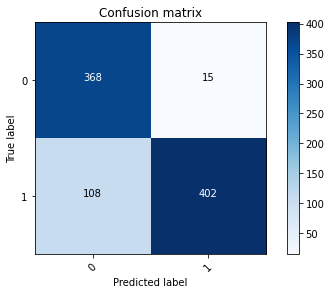

In [346]:
pred12 =linear_clf.predict(test_vectors_dbow)
score12 = metrics.accuracy_score(y_test, pred12)
print("accuracy:   %0.3f" % score12)
cm12 = metrics.confusion_matrix(y_test, pred12)
plot_confusion_matrix(cm12, classes=['0', '1'])
print(classification_report(y_test,pred12))

Ensemble Learning Classification Algorithams

In [347]:
from sklearn.ensemble import RandomForestClassifier


In [348]:
%%time
rfcf=RandomForestClassifier()
rfcf.fit(train_vectors_dbow, y_train)

CPU times: user 7.01 s, sys: 6.5 ms, total: 7.02 s
Wall time: 6.99 s


accuracy:   0.92049
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       383
           1       0.90      0.96      0.93       510

    accuracy                           0.92       893
   macro avg       0.92      0.91      0.92       893
weighted avg       0.92      0.92      0.92       893



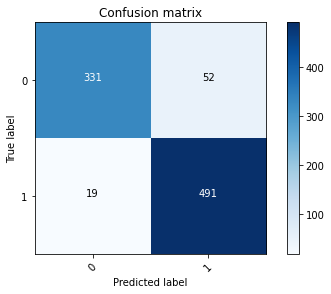

In [350]:

pred2 =rfcf.predict(test_vectors_dbow)
score2 = metrics.accuracy_score(y_test, pred2)
print("accuracy:   %0.5f" % score2)
cm2 = metrics.confusion_matrix(y_test, pred2)
plot_confusion_matrix(cm2, classes=['0', '1'])
print(classification_report(y_test,pred2))

In [351]:
from sklearn.ensemble import GradientBoostingClassifier


In [355]:
%%time
gbrt =GradientBoostingClassifier(random_state=1, subsample=0.5)

gbrt.fit(train_vectors_dbow, y_train)


CPU times: user 1min 49s, sys: 62.8 ms, total: 1min 49s
Wall time: 1min 48s


accuracy:   0.928
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       383
           1       0.93      0.95      0.94       510

    accuracy                           0.93       893
   macro avg       0.93      0.93      0.93       893
weighted avg       0.93      0.93      0.93       893



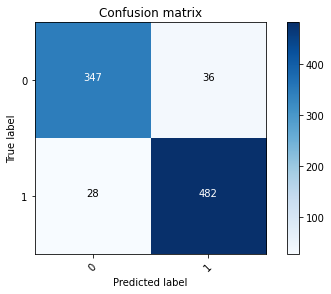

In [356]:

pred3 =gbrt.predict(test_vectors_dbow)
score3 = metrics.accuracy_score(y_test, pred3)
print("accuracy:   %0.3f" % score3)
cm3 = metrics.confusion_matrix(y_test, pred3)
plot_confusion_matrix(cm3, classes=['0', '1'])
print(classification_report(y_test,pred3))

In [357]:
from sklearn.ensemble import AdaBoostClassifier

In [358]:
ada = AdaBoostClassifier( n_estimators=180, random_state=1)
ada.fit(train_vectors_dbow, y_train)

AdaBoostClassifier(n_estimators=180, random_state=1)

accuracy:   0.92945
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       383
           1       0.93      0.94      0.94       510

    accuracy                           0.93       893
   macro avg       0.93      0.93      0.93       893
weighted avg       0.93      0.93      0.93       893



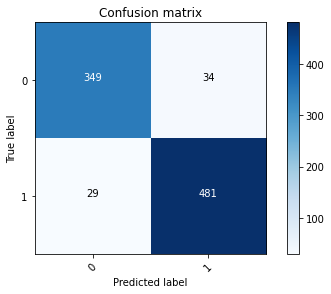

In [359]:
pred4 =ada.predict(test_vectors_dbow)
score4 = metrics.accuracy_score(y_test, pred4)
print("accuracy:   %0.5f" % score4)
cm4 = metrics.confusion_matrix(y_test, pred4)
plot_confusion_matrix(cm4, classes=['0', '1'])
print(classification_report(y_test,pred4))

In [360]:
from sklearn.ensemble import VotingClassifier

In [361]:
models = [('ada',AdaBoostClassifier(n_estimators=180, random_state=1)),('rfcf',RandomForestClassifier()),('gbrt',GradientBoostingClassifier(random_state=1, subsample=0.5))]

In [362]:
voting_clas_hard = VotingClassifier(voting='hard', estimators=models )
voting_clas_hard.fit(train_vectors_dbow, y_train)

VotingClassifier(estimators=[('ada',
                              AdaBoostClassifier(n_estimators=180,
                                                 random_state=1)),
                             ('rfcf', RandomForestClassifier()),
                             ('gbrt',
                              GradientBoostingClassifier(random_state=1,
                                                         subsample=0.5))])

accuracy:   0.934
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       383
           1       0.93      0.96      0.94       510

    accuracy                           0.93       893
   macro avg       0.93      0.93      0.93       893
weighted avg       0.93      0.93      0.93       893



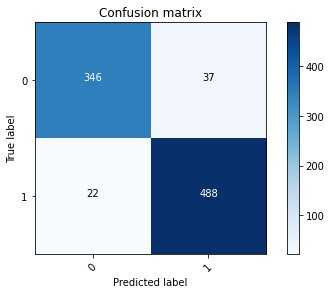

In [364]:
pred13 =voting_clas_hard.predict(test_vectors_dbow)
score13 = metrics.accuracy_score(y_test, pred13)
print("accuracy:   %0.3f" % score13)
cm13 = metrics.confusion_matrix(y_test, pred13)
plot_confusion_matrix(cm13, classes=['0', '1'])
print(classification_report(y_test,pred13))

Cross-Validation

In [ ]:
from sklearn.model_selection import KFold
kfold_validation1=KFold(10)

In [ ]:
from sklearn.model_selection import StratifiedKFold
kfold_validation=StratifiedKFold(n_splits=10)

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score


In [ ]:
from gensim.models import doc2vec

def label_sentences1(corpus, label_type):
    
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

In [ ]:
X1=df.Post
all_data1 = label_sentences1(X1, 'All')



In [ ]:

model_dbow1 = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow1.build_vocab([x for x in tqdm(all_data1)])


100%|██████████| 2704/2704 [00:00<00:00, 1197107.66it/s]


In [ ]:
%%time
for epoch in range(30):
    model_dbow1.train(utils.shuffle([x for x in tqdm(all_data1)]), total_examples=len(all_data1), epochs=1)
    model_dbow1.alpha -= 0.002
    model_dbow1.min_alpha = model_dbow1.alpha

100%|██████████| 2704/2704 [00:00<00:00, 1805380.14it/s]


CPU times: user 14.1 s, sys: 845 ms, total: 14.9 s
Wall time: 8.9 s


In [ ]:
def get_vectors1(model, corpus_size, vectors_size, vectors_type):
    
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
train_vectors_dbow1 = get_vectors1(model_dbow1, len(all_data1), 300, 'All')
train_vectors_dbow1 

array([[ 0.02126081,  0.04569095, -0.18670408, ..., -0.1112036 ,
         0.06855348, -0.11463564],
       [ 0.39436278,  0.11177636,  0.12055359, ..., -0.0308714 ,
         0.27338985,  0.03963906],
       [ 0.17490959, -0.03561036, -0.05103262, ...,  0.08461513,
        -0.06399523, -0.32201269],
       ...,
       [ 0.25188258, -0.07814928,  0.00120707, ..., -0.02598551,
         0.1218982 ,  0.16509211],
       [-0.17763907, -0.23738742, -0.30374765, ...,  0.10426784,
         0.17630519, -0.07287445],
       [ 0.10200619,  0.08667233,  0.04220365, ..., -0.01521376,
        -0.12899943,  0.04803993]])

In [ ]:
results_LR=cross_val_score(logreg,train_vectors_dbow1,y,cv=kfold_validation)
print(results_LR)
print(np.average(results_LR))

[0.87084871 0.92250923 0.94833948 0.94464945 0.92962963 0.93333333
 0.89259259 0.88518519 0.94074074 0.91111111]
0.9178939456061228


In [ ]:
results_naive_gaussian=cross_val_score(naive_gaussian,train_vectors_dbow1,y,cv=kfold_validation)
print(results_naive_gaussian)
print(np.average(results_naive_gaussian))

[0.58671587 0.77121771 0.82287823 0.86346863 0.85185185 0.85925926
 0.88888889 0.88148148 0.77037037 0.76296296]
0.8059095257619244


In [ ]:
results_dt=cross_val_score(dt,train_vectors_dbow1,y,cv=kfold_validation)
print(results_dt)
print(np.average(results_dt))

[0.73431734 0.80073801 0.80811808 0.81180812 0.76666667 0.79259259
 0.76296296 0.71851852 0.8037037  0.80740741]
0.780683340166735


In [ ]:
results_rfcf=cross_val_score(rfcf,train_vectors_dbow1,y,cv=kfold_validation)
print(results_rfcf)
print(np.average(results_rfcf))

[0.81918819 0.92619926 0.90405904 0.91881919 0.91481481 0.91111111
 0.91111111 0.88148148 0.8962963  0.91111111]
0.8994191608582753


In [ ]:
results_gbrt=cross_val_score(gbrt,train_vectors_dbow1,y,cv=kfold_validation)
print(results_gbrt)
print(np.average(results_gbrt))

[0.83763838 0.91881919 0.91881919 0.94833948 0.95185185 0.94074074
 0.88148148 0.9        0.95185185 0.94814815]
0.9197690310236435


In [ ]:
results_ada=cross_val_score(ada,train_vectors_dbow1,y,cv=kfold_validation)
print(results_ada)
print(np.average(results_ada))

[0.83763838 0.900369   0.92250923 0.95940959 0.94814815 0.93703704
 0.88148148 0.8962963  0.93703704 0.94444444]
0.9164370643706438


In [ ]:
results_linear_clf=cross_val_score(linear_clf,train_vectors_dbow1,y,cv=kfold_validation)
print(results_linear_clf)
print(np.average(results_linear_clf))




[0.81918819 0.85608856 0.92619926 0.94464945 0.87777778 0.9037037
 0.85925926 0.82222222 0.92592593 0.88888889]
0.882390323903239


In [ ]:
results_voting_clas_hard=cross_val_score(voting_clas_hard,train_vectors_dbow1,y,cv=kfold_validation)
print(results_voting_clas_hard)
print(np.average(results_voting_clas_hard))


[0.84132841 0.90774908 0.92619926 0.95202952 0.94444444 0.94814815
 0.90740741 0.9037037  0.94814815 0.95185185]
0.9231009976766436


In [ ]:
results_svm=cross_val_score(clf,train_vectors_dbow1,y,cv=kfold_validation)
print(results_svm)
print(np.average(results_svm))


[0.86346863 0.91512915 0.92250923 0.94464945 0.94074074 0.93703704
 0.89259259 0.89259259 0.92962963 0.9037037 ]
0.9142052753860872
